In [21]:
# 1️⃣ Hospital & department capacity setup (UKE-focused)

import random

# --- ICU units (real counts) -----------------------------------------------
# Each ICU must reserve 1 bed for resuscitation => operational_beds = total_beds - 1
ICU_TOTAL_BEDS = {
    "neurochirurgical_icu": 12,
    "neurological_icu": 12,
    "interdis_stage1": 12,     # UKE 1C
    "interdis_stage2": 12,     # UKE 1D
    "interdis_stage3": 12,     # UKE 1E
    "surgical_icu": 12,        # UKE 1F
    "internal_medicine_icu": 12,  # UKE 1G
    "cardio_icu": 12,          # UKE H1b (cardiology)
    "cardio_surgery_icu": 12,  # UKE H1b (cardiac surgery)
    "vascular_cardiac_icu": 8  # UKE H2b
}

ICU_OPERATIONAL_BEDS = {
    k: max(v - 1, 0) for k, v in ICU_TOTAL_BEDS.items()
}

# --- Non-ICU departments (simulated sizes) ----------------------------------
# Rule of thumb: Large=50, Medium=30, Small=20
DEPARTMENTS_SIZE = {
    # Large
    "internal_medicine": 50,
    "neurology": 50,
    "surgery_general": 50,

    # Medium
    "cardiology": 30,
    "pulmonology": 30,
    "gastroenterology": 30,
    "orthopedics": 30,
    "surgery_trauma": 30,
    "vascular_surgery": 30,

    # Small
    "oncology": 20,
    "pediatrics": 20,
    "obstetrics_gynecology": 20,
    "psychiatry": 20,
    "palliative": 20,
    "imc_internal_medicine": 20,
}

# Combine into a single capacity registry (operational bed counts)
OPER_BEDS = {
    **ICU_OPERATIONAL_BEDS,
    **DEPARTMENTS_SIZE
}

# --- Availability sampling ---------------------------------------------------
# Availability is sampled per patient/event: 0%..50% free, with a small chance of 0% hard block
def sample_availability_fraction(hard_block_prob: float = 0.10) -> float:
    """Return a fraction of free capacity in [0.0, 0.5]. Sometimes forced to 0.0."""
    if random.random() < hard_block_prob:
        return 0.0
    return random.uniform(0.0, 0.5)

def capacity_snapshot_normalized(hard_block_prob: float = 0.10) -> dict:
    """
    Produce a dict of normalized capacity scores per department (0..1),
    computed as available_beds / operational_beds for the current moment.
    """
    snap = {}
    for dept, oper_beds in OPER_BEDS.items():
        if oper_beds <= 0:
            snap[dept] = 0.0
            continue
        frac = sample_availability_fraction(hard_block_prob)
        available = int(round(oper_beds * frac))
        snap[dept] = available / oper_beds
    return snap

# Convenience lists if needed later
ICU_DEPARTMENTS = list(ICU_OPERATIONAL_BEDS.keys())
NON_ICU_DEPARTMENTS = list(DEPARTMENTS_SIZE.keys())
ALL_DEPARTMENTS = list(OPER_BEDS.keys())

# Sanity print (optional)
print("ICU operational beds:", ICU_OPERATIONAL_BEDS)
print("Non-ICU sizes:", DEPARTMENTS_SIZE)


ICU operational beds: {'neurochirurgical_icu': 11, 'neurological_icu': 11, 'interdis_stage1': 11, 'interdis_stage2': 11, 'interdis_stage3': 11, 'surgical_icu': 11, 'internal_medicine_icu': 11, 'cardio_icu': 11, 'cardio_surgery_icu': 11, 'vascular_cardiac_icu': 7}
Non-ICU sizes: {'internal_medicine': 50, 'neurology': 50, 'surgery_general': 50, 'cardiology': 30, 'pulmonology': 30, 'gastroenterology': 30, 'orthopedics': 30, 'surgery_trauma': 30, 'vascular_surgery': 30, 'oncology': 20, 'pediatrics': 20, 'obstetrics_gynecology': 20, 'psychiatry': 20, 'palliative': 20, 'imc_internal_medicine': 20}


In [22]:
# 2️⃣ Patient generator using real ICU and simulated non-ICU capacities

import uuid
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

# Fixed suspected conditions for now
SUSPECTED_CONDITIONS = [
    "cardiac", "respiratory", "neurological",
    "gastrointestinal", "oncology", "infection", "trauma"
]

HOME_TYPES = ["private", "nursing_home"]

def generate_patient():
    # Static patient attributes
    patient_id = str(uuid.uuid4())[:8]
    age = np.random.randint(18, 95)
    home_type = np.random.choice(HOME_TYPES)
    suspected_condition = np.random.choice(SUSPECTED_CONDITIONS)
    
    # EMS and ED timing
    ems_start_time = datetime(2025, 8, 7) + timedelta(
        hours=np.random.randint(0, 24),
        minutes=np.random.randint(0, 60)
    )
    ems_triage_code = np.random.randint(1, 5)  # 1=most urgent, 4=least
    ems_target_hospital = "UKE"
    ed_arrival_time = ems_start_time + timedelta(minutes=np.random.randint(5, 30))

    # Capacity snapshot for all departments (normalized)
    capacities = capacity_snapshot_normalized()

    # Target: for now, simple suitability score for ward assignment
    ward_assignment_suitability = np.random.uniform(0, 1)

    # Combine all fields
    record = {
        "patient_id": patient_id,
        "age": age,
        "home_type": home_type,
        "suspected_condition": suspected_condition,
        "ems_start_time": ems_start_time,
        "ems_triage_code": ems_triage_code,
        "ems_target_hospital": ems_target_hospital,
        "ed_arrival_time": ed_arrival_time,
    }

    # Add department capacities as features
    for dept, cap in capacities.items():
        record[f"cap_{dept}"] = cap

    # Output target(s)
    record["ward_assignment_suitability"] = ward_assignment_suitability

    return record

def generate_dataset(n_patients=500):
    patients = [generate_patient() for _ in range(n_patients)]
    return pd.DataFrame(patients)

# Quick test
df = generate_dataset(5)
print(df.head())
print("\nShape:", df.shape)


  patient_id  age     home_type suspected_condition      ems_start_time  \
0   5c927a1d   85       private        neurological 2025-08-07 17:52:00   
1   d0317e1e   32  nursing_home             cardiac 2025-08-07 09:21:00   
2   93c370ab   25       private            oncology 2025-08-07 21:45:00   
3   b0bc3a0a   39  nursing_home           infection 2025-08-07 08:44:00   
4   aa402764   44       private           infection 2025-08-07 07:55:00   

   ems_triage_code ems_target_hospital     ed_arrival_time  \
0                2                 UKE 2025-08-07 18:09:00   
1                4                 UKE 2025-08-07 09:50:00   
2                1                 UKE 2025-08-07 22:02:00   
3                3                 UKE 2025-08-07 09:06:00   
4                3                 UKE 2025-08-07 08:20:00   

   cap_neurochirurgical_icu  cap_neurological_icu  ...  cap_orthopedics  \
0                  0.363636              0.000000  ...         0.466667   
1                  0.45454

In [23]:
def generate_patient():
    patient_id = str(uuid.uuid4())[:8]

    # Demographics
    age = np.random.randint(0, 100)
    home_type = random.choice(['private', 'nursing_home'])

    # Clinical presentation
    suspected_condition = random.choice([
        'cardiac', 'respiratory', 'neurological',
        'infection', 'trauma', 'oncology', 'gastrointestinal'
    ])

    # EMS data
    ems_start_time = datetime(2025, 8, 7) + timedelta(
        hours=np.random.randint(0, 24),
        minutes=np.random.randint(0, 60)
    )
    ems_triage_code = np.random.choice([1, 2, 3, 4], p=[0.1, 0.2, 0.4, 0.3])
    ems_target_hospital = "UKE"  # fixed

    # ED arrival time
    travel_time_min = np.random.randint(5, 25)
    ed_arrival_time = ems_start_time + timedelta(minutes=travel_time_min)

    # Derived features
    day_of_week = ed_arrival_time.strftime("%A")
    hour_of_day = ed_arrival_time.hour

    # Capacities — ICU real values minus 1 bed for resus
    icu_capacities = {
        'neurochirurgical_icu': 11,
        'neurological_icu': 11,
        'interdis_stage1': 11,
        'interdis_stage2': 11,
        'interdis_stage3': 11,
        'surgical_icu': 11,
        'internal_medicine_icu': 11,
        'cardio_icu': 11,
        'cardio_surgery_icu': 11,
        'vascular_cardiac_icu': 7
    }

    # Simulate ICU availability between 0–100% of operational beds
    icu_caps = {f"cap_{k}": round(np.random.randint(0, beds + 1) / beds, 2)
                for k, beds in icu_capacities.items()}

    # Non-ICU sizes
    non_icu_sizes = {
        'internal_medicine': 50,
        'neurology': 50,
        'surgery_general': 50,
        'cardiology': 30,
        'pulmonology': 30,
        'gastroenterology': 30,
        'orthopedics': 30,
        'surgery_trauma': 30,
        'vascular_surgery': 30,
        'oncology': 20,
        'pediatrics': 20,
        'obstetrics_gynecology': 20,
        'psychiatry': 20,
        'palliative': 20,
        'imc_internal_medicine': 20
    }

    # Simulate availability 0–50% for non-ICU wards
    non_icu_caps = {f"cap_{k}": round(np.random.randint(0, int(beds * 0.5) + 1) / beds, 2)
                    for k, beds in non_icu_sizes.items()}

    # Output variable — ground truth
    ward_assignment_suitability = round(np.clip(np.random.normal(0.7, 0.15), 0, 1), 3)

    return {
        "patient_id": patient_id,
        "age": age,
        "home_type": home_type,
        "suspected_condition": suspected_condition,
        "ems_start_time": ems_start_time,
        "ems_triage_code": ems_triage_code,
        "ems_target_hospital": ems_target_hospital,
        "ed_arrival_time": ed_arrival_time,
        "day_of_week": day_of_week,
        "hour_of_day": hour_of_day,
        **icu_caps,
        **non_icu_caps,
        "ward_assignment_suitability": ward_assignment_suitability
    }


In [24]:
# 4️⃣ Generate dataset with expanded capacity features
def generate_dataset(n_patients=500):
    return [generate_patient() for _ in range(n_patients)]

df = pd.DataFrame(generate_dataset(n_patients=500))

# Basic hygiene
assert df.isna().sum().sum() == 0, "Found unexpected NaNs — check generator."
assert (df["ems_triage_code"].between(1, 4)).all(), "ems_triage_code out of expected bounds."

print("Shape:", df.shape)
print("Columns:", list(df.columns))

print("\nValue counts — suspected_condition:")
print(df["suspected_condition"].value_counts())

print("\nValue counts — home_type:")
print(df["home_type"].value_counts())

display(df.head(3))


Shape: (500, 36)
Columns: ['patient_id', 'age', 'home_type', 'suspected_condition', 'ems_start_time', 'ems_triage_code', 'ems_target_hospital', 'ed_arrival_time', 'day_of_week', 'hour_of_day', 'cap_neurochirurgical_icu', 'cap_neurological_icu', 'cap_interdis_stage1', 'cap_interdis_stage2', 'cap_interdis_stage3', 'cap_surgical_icu', 'cap_internal_medicine_icu', 'cap_cardio_icu', 'cap_cardio_surgery_icu', 'cap_vascular_cardiac_icu', 'cap_internal_medicine', 'cap_neurology', 'cap_surgery_general', 'cap_cardiology', 'cap_pulmonology', 'cap_gastroenterology', 'cap_orthopedics', 'cap_surgery_trauma', 'cap_vascular_surgery', 'cap_oncology', 'cap_pediatrics', 'cap_obstetrics_gynecology', 'cap_psychiatry', 'cap_palliative', 'cap_imc_internal_medicine', 'ward_assignment_suitability']

Value counts — suspected_condition:
suspected_condition
gastrointestinal    79
trauma              79
cardiac             71
neurological        71
oncology            69
infection           68
respiratory         

,patient_id,age,home_type,suspected_condition,ems_start_time,ems_triage_code,ems_target_hospital,ed_arrival_time,day_of_week,hour_of_day,...,cap_orthopedics,cap_surgery_trauma,cap_vascular_surgery,cap_oncology,cap_pediatrics,cap_obstetrics_gynecology,cap_psychiatry,cap_palliative,cap_imc_internal_medicine,ward_assignment_suitability
0,96082509,14,nursing_home,gastrointestinal,2025-08-07 09:25:00,2,UKE,2025-08-07 09:36:00,Thursday,9,...,0.07,0.13,0.43,0.10,0.20,0.35,0.00,0.05,0.05,0.605
1,f7fd26a2,33,nursing_home,cardiac,2025-08-07 13:10:00,3,UKE,2025-08-07 13:21:00,Thursday,13,...,0.03,0.17,0.43,0.10,0.00,0.10,0.25,0.10,0.40,0.688
2,3b6ba8e5,70,private,cardiac,2025-08-07 13:36:00,3,UKE,2025-08-07 13:49:00,Thursday,13,...,0.27,0.23,0.33,0.15,0.05,0.05,0.05,0.50,0.25,0.547


In [25]:
# 5️⃣ Preprocessing setup for expanded capacity dataset

# Feature lists
FEATS_CAT = ["home_type", "suspected_condition", "day_of_week"]
FEATS_NUM = ["age", "ems_triage_code", "hour_of_day"] + \
            [c for c in df.columns if c.startswith("cap_")]

TARGET = "ward_assignment_suitability"

# Split
X = df[FEATS_CAT + FEATS_NUM]
y = df[TARGET]

X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.4, random_state=42
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42
)

print(f"Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")

# Preprocessing pipeline
pre = ColumnTransformer([
    ("cat", OneHotEncoder(handle_unknown="ignore"), FEATS_CAT),
    ("num", StandardScaler(), FEATS_NUM)
])


Train: (300, 31), Val: (100, 31), Test: (100, 31)


In [26]:
# Ridge regression sanity check
import time
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error

start_time = time.time()

# Preprocessor (re-using FEATS_CAT and FEATS_NUM from before)
pre = ColumnTransformer([
    ("cat", OneHotEncoder(handle_unknown="ignore"), FEATS_CAT),
    ("num", StandardScaler(), FEATS_NUM)
])

model = Pipeline([
    ("pre", pre),
    ("reg", Ridge(alpha=1.0))
])

# Train
model.fit(X_train, y_train)

# Validate
y_val_pred = model.predict(X_val)
mse = mean_squared_error(y_val, y_val_pred)
mae = mean_absolute_error(y_val, y_val_pred)

end_time = time.time()

print(f"Validation MSE: {mse:.4f}")
print(f"Validation MAE: {mae:.4f}")
print(f"Training time: {end_time - start_time:.2f} seconds")


Validation MSE: 0.0231
Validation MAE: 0.1271
Training time: 0.02 seconds


In [27]:
# 🔹 Step 1: Preprocess with expanded feature set
FEATS_CAT = ["home_type", "suspected_condition", "day_of_week"]
FEATS_NUM = [
    "age", "ems_triage_code", "hour_of_day",
    # All capacity columns
] + [col for col in df.columns if col.startswith("cap_")]

TARGET = "ward_assignment_suitability"

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

pre = ColumnTransformer([
    ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), FEATS_CAT),
    ("num", StandardScaler(), FEATS_NUM)
])

X_train_np = pre.fit_transform(X_train)
X_val_np   = pre.transform(X_val)
X_test_np  = pre.transform(X_test)

y_train_np = y_train.values.astype("float32")
y_val_np   = y_val.values.astype("float32")
y_test_np  = y_test.values.astype("float32")

print("Shapes:", X_train_np.shape, X_val_np.shape, X_test_np.shape)

# 🔹 Step 2: Convert to torch tensors and loaders
import torch
from torch.utils.data import TensorDataset, DataLoader

Xtr = torch.tensor(X_train_np, dtype=torch.float32)
ytr = torch.tensor(y_train_np.reshape(-1, 1), dtype=torch.float32)
Xva = torch.tensor(X_val_np, dtype=torch.float32)
yva = torch.tensor(y_val_np.reshape(-1, 1), dtype=torch.float32)
Xte = torch.tensor(X_test_np, dtype=torch.float32)
yte = torch.tensor(y_test_np.reshape(-1, 1), dtype=torch.float32)

train_loader = DataLoader(TensorDataset(Xtr, ytr), batch_size=64, shuffle=True)
val_loader   = DataLoader(TensorDataset(Xva, yva), batch_size=256)
test_loader  = DataLoader(TensorDataset(Xte, yte), batch_size=256)

input_dim = Xtr.shape[1]
print("Input dim:", input_dim)

# 🔹 Step 3: Define the MLP
import torch.nn as nn
import torch.optim as optim
import numpy as np

class MLP(nn.Module):
    def __init__(self, d_in):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(d_in, 128), nn.ReLU(), nn.Dropout(0.1),
            nn.Linear(128, 64), nn.ReLU(),
            nn.Linear(64, 1)
        )
    def forward(self, x):
        return self.net(x)

mlp = MLP(input_dim)

criterion = nn.MSELoss()
optimizer = optim.Adam(mlp.parameters(), lr=1e-3)

# 🔹 Step 4: Training loop with early stopping
best_val = np.inf
patience, bad = 8, 0
epochs = 50

for ep in range(1, epochs + 1):
    mlp.train()
    train_loss = 0.0
    for xb, yb in train_loader:
        optimizer.zero_grad()
        pred = mlp(xb)
        loss = criterion(pred, yb)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * xb.size(0)
    train_loss /= len(train_loader.dataset)

    mlp.eval()
    val_loss = 0.0
    with torch.no_grad():
        for xb, yb in val_loader:
            val_loss += criterion(mlp(xb), yb).item() * xb.size(0)
    val_loss /= len(val_loader.dataset)

    print(f"Epoch {ep:02d} | train MSE {train_loss:.4f} | val MSE {val_loss:.4f}")

    if val_loss + 1e-6 < best_val:
        best_val = val_loss
        bad = 0
        best_state = {k: v.cpu().clone() for k, v in mlp.state_dict().items()}
    else:
        bad += 1
        if bad >= patience:
            print("Early stopping.")
            break

mlp.load_state_dict(best_state)


Shapes: (300, 38) (100, 38) (100, 38)
Input dim: 38
Epoch 01 | train MSE 0.1866 | val MSE 0.0524
Epoch 02 | train MSE 0.0403 | val MSE 0.0685
Epoch 03 | train MSE 0.0616 | val MSE 0.0529
Epoch 04 | train MSE 0.0377 | val MSE 0.0317
Epoch 05 | train MSE 0.0297 | val MSE 0.0366
Epoch 06 | train MSE 0.0293 | val MSE 0.0323
Epoch 07 | train MSE 0.0247 | val MSE 0.0290
Epoch 08 | train MSE 0.0209 | val MSE 0.0307
Epoch 09 | train MSE 0.0206 | val MSE 0.0294
Epoch 10 | train MSE 0.0201 | val MSE 0.0285
Epoch 11 | train MSE 0.0181 | val MSE 0.0284
Epoch 12 | train MSE 0.0174 | val MSE 0.0284
Epoch 13 | train MSE 0.0160 | val MSE 0.0289
Epoch 14 | train MSE 0.0156 | val MSE 0.0290
Epoch 15 | train MSE 0.0147 | val MSE 0.0291
Epoch 16 | train MSE 0.0136 | val MSE 0.0290
Epoch 17 | train MSE 0.0145 | val MSE 0.0289
Epoch 18 | train MSE 0.0129 | val MSE 0.0287
Epoch 19 | train MSE 0.0128 | val MSE 0.0289
Early stopping.


<All keys matched successfully>

MLP Test MSE: 0.0256 | MAE: 0.1313


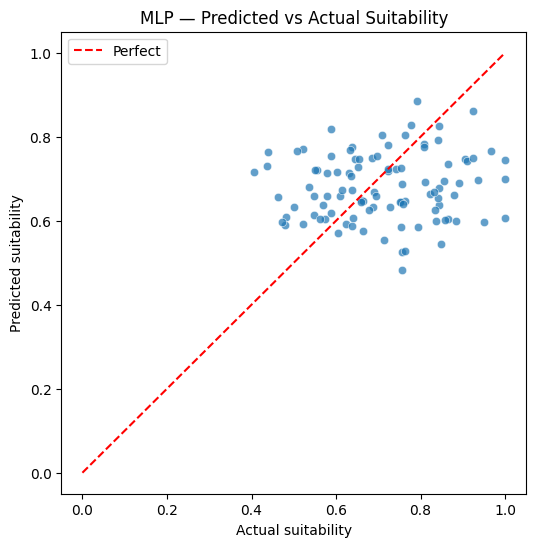

In [28]:
# Test set evaluation
mlp.eval()
with torch.no_grad():
    y_pred_test = np.vstack([mlp(xb).cpu().numpy() for xb, _ in test_loader]).ravel()

mse_test = mean_squared_error(y_test_np, y_pred_test)
mae_test = mean_absolute_error(y_test_np, y_pred_test)

print(f"MLP Test MSE: {mse_test:.4f} | MAE: {mae_test:.4f}")

# Scatter plot
plt.figure(figsize=(6,6))
sns.scatterplot(x=y_test_np, y=y_pred_test, alpha=0.7)
plt.plot([0,1], [0,1], 'r--', label="Perfect")
plt.xlabel("Actual suitability")
plt.ylabel("Predicted suitability")
plt.title("MLP — Predicted vs Actual Suitability")
plt.legend()
plt.show()


In [30]:
# Cell PI-1 — Get feature names + define a predict helper
import numpy as np

# Recover feature names from the fitted preprocessor used for X_*_np
cat_names = pre.named_transformers_["cat"].get_feature_names_out(FEATS_CAT)
num_names = np.array(FEATS_NUM, dtype=str)
feature_names = np.concatenate([cat_names, num_names])

assert feature_names.shape[0] == X_test_np.shape[1], (
    f"Name/feature mismatch: {feature_names.shape[0]} vs {X_test_np.shape[1]}"
)

# Torch → numpy prediction helper on raw numpy features
import torch

def mlp_predict_numpy(X_np: np.ndarray) -> np.ndarray:
    X_tensor = torch.tensor(X_np, dtype=torch.float32)
    mlp.eval()
    with torch.no_grad():
        y_hat = mlp(X_tensor).cpu().numpy().ravel()
    return y_hat



Baseline test MSE: 0.0256


,feature,perm_mse_increase
11,ems_triage_code,0.001192
28,cap_gastroenterology,0.000992
0,home_type_nursing_home,0.000939
14,cap_neurological_icu,0.000881
16,cap_interdis_stage2,0.000639
17,cap_interdis_stage3,0.000291
36,cap_palliative,0.000251
23,cap_internal_medicine,0.000243
12,hour_of_day,0.000237
7,suspected_condition_respiratory,0.000132


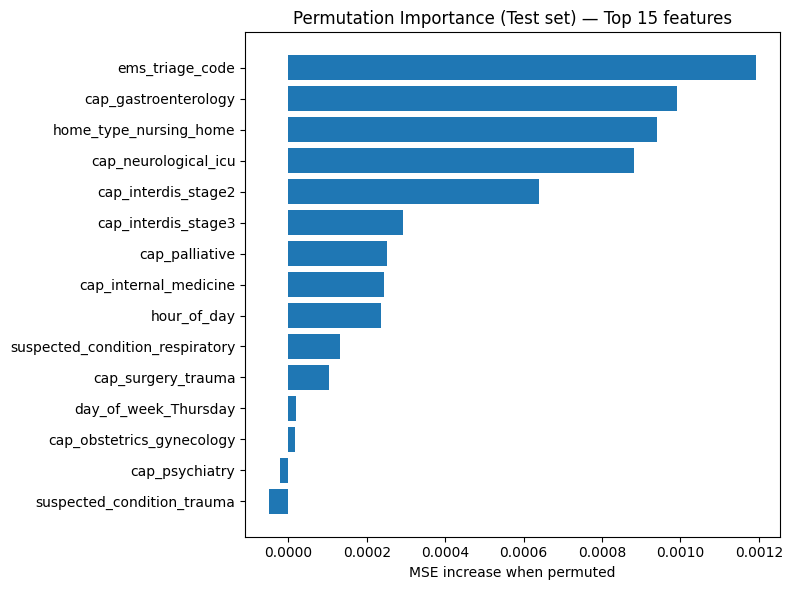

In [31]:
# Cell PI-2 — Permutation importance (on test set)
from sklearn.metrics import mean_squared_error
import pandas as pd
import matplotlib.pyplot as plt

def permutation_importance_torch(predict_fn, X, y, n_repeats=10, seed=42):
    rng = np.random.default_rng(seed)
    baseline = mean_squared_error(y, predict_fn(X))
    importances = np.zeros(X.shape[1], dtype=float)

    for j in range(X.shape[1]):
        losses = []
        X_perm = X.copy()
        for _ in range(n_repeats):
            rng.shuffle(X_perm[:, j])   # in-place column shuffle
            y_hat = predict_fn(X_perm)
            losses.append(mean_squared_error(y, y_hat))
        importances[j] = np.mean(losses) - baseline
    return importances, baseline

imps, base_mse = permutation_importance_torch(mlp_predict_numpy, X_test_np, y_test_np, n_repeats=20)

imp_df = pd.DataFrame({
    "feature": feature_names,
    "perm_mse_increase": imps
}).sort_values("perm_mse_increase", ascending=False)

print(f"Baseline test MSE: {base_mse:.4f}")
display(imp_df.head(20))

# Plot top 15
top = imp_df.head(15).iloc[::-1]  # reverse for nicer barh
plt.figure(figsize=(8, 6))
plt.barh(top["feature"], top["perm_mse_increase"])
plt.xlabel("MSE increase when permuted")
plt.title("Permutation Importance (Test set) — Top 15 features")
plt.tight_layout()
plt.show()


In [34]:
# Cell PI-3 — Quick grouping summary
# This helps see ICU if capacities matter more than non-ICU.

imp_df["group"] = np.where(
    imp_df["feature"].str.contains("cap_"),
    np.where(
        imp_df["feature"].str.contains("cap_(neurochirurgical_icu|neurological_icu|interdis_stage|surgical_icu|internal_medicine_icu|cardio_icu|cardio_surgery_icu|vascular_cardiac_icu)"),
        "ICU capacity",
        "Non-ICU capacity"
    ),
    "Other"
)

group_summary = imp_df.groupby("group")["perm_mse_increase"].sum().reset_index().sort_values("perm_mse_increase", ascending=False)
display(group_summary)


/tmp/ipykernel_36/1380963759.py:7: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  imp_df["feature"].str.contains("cap_(neurochirurgical_icu|neurological_icu|interdis_stage|surgical_icu|internal_medicine_icu|cardio_icu|cardio_surgery_icu|vascular_cardiac_icu)"),


,group,perm_mse_increase
2,Other,0.000405
1,Non-ICU capacity,-0.001504
0,ICU capacity,-0.002626
